# Table of Contents

### [1. Introduction to Patents](#1)
### [2. Data Sighting, Preparation and Preliminary Analysis](#2)
- [2.1 Sighting](#21)
- [2.2 Preprocessing](#22)
- [2.3 Processing](#23)

### [3. Preliminary Statistics](#3)
- [3.1 Histograms over Time](#31)
- [3.2 Histograms over Types](#32)

### [4. Graph software](#4)

- [4.1 What we tried](#41)
- [4.2 Graph visualisation using graph-tool](#42)
- [4.3 Transforming the citations dataframe to a directed graph](#43)
- [4.4 Saving the graph to disk](#44)

### [5. Statistics on the graph](#5)

- [5.1 Working with the graph](#51)
- [5.2 Graph overview](#52)
- [5.3 Vertex in- and out-degrees](#53)
- [5.4 Shortest path between selected nodes](#54)
- [5.5 Speed of complex graph algorithms](#55)
- [5.6 Connected Components](#56)

### [6. Most important patents](#6)

### [7. Shortest path between multiple sources and sinks](#7)

### [8. Shortest paths with distances](#8)

### [9. Visualisation of the lifetime of a node and its closest neighbours](#9)

# 1. Introduction to Patents <a id="1"></a>

<img src="./graphics/graph_seal.png" alt="Drawing" style="width: 500px;"/>

The data used in this project is provided by the [patentsview.org](http://www.patentsview.org) website of the United States Patent and Trademark Office ([USPTO](https://www.uspto.gov/)). 

The USTPO defines a patent as a property right granted by the Government of the United States of America to an inventor "to exclude others from making, using, offering for sale, or selling the invention throughout the United States or importing the invention into the United States" for a limited time in exchange for public disclosure of the invention when the patent is granted.

On their [getting started webpage](https://www.uspto.gov/patents-getting-started/general-information-concerning-patents) the USTPO states, that there are three types of patents:


- Utility patents may be granted to anyone who invents or discovers any new and useful process, machine, article of manufacture, or composition of matter, or any new and useful improvement thereof;


-  Design patents may be granted to anyone who invents a new, original, and ornamental design for an article of manufacture;


-  Plant patents may be granted to anyone who invents or discovers and asexually reproduces any distinct and new variety of plant.


In this project we wish to investigate patents related to technology, which led to the decision of dropping all data concerning plant patents, leaving us, after further cleaning explained below, with a graph built of roughly 90 million edges.


There are two main stages in the process of receiving a granted patent for an invention. First a patent application needs to be filed. If the application meets the filing requirements it is awarded with a filing date and an application number. Once a filing date is assigned, the claimed invention is officially “patent pending”. In the next stage a patent examiner is assigned, who is responsible for reviewing the application. This is a lengthy process and can span multiple years. When the USTPO determines a patent application is patentable, it assigns a patent number and issues the patent. 
This is the number we use throughout this project.

In addition to patents view we also consult the [google patents database](https://patents.google.com/) during this project, which provides lengthier textual descriptions and original images of individual patents.

# 2. Data Sighting, Preparation and Preliminary Analysis <a id="2"></a>

The USTPO provides all relevant patent data starting from 1976 to the current year in tab-separated files.<br>
For the rest of this notebook we focused our efforts on the following data sets.
 - Citations
 - General patent data
 - Categories and category mapping

In [1]:
%matplotlib inline

In [497]:
import heapq
import requests
import json
import time
import csv
import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from graph_tool.all import *

In [94]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)
sns.set_palette('deep')
sns.set()

In [4]:
DATA = './data/'

## 2.1 Sighting <a id="21"></a>

### Citations

The citations sheet is the core data set of our project. It provides the base of our graph and is by far the biggest file in our collection at almost 8 gigabytes. The raw file is a bit noisy and contains some less relevant columns. In detail:
 - **uuid**: Unique citation identifier chosen by PatentView for disambiguiation.
 - **patent_id**: USPTO identifier of citing patent
 - **citation_id**: USPTO identifier of cited patent
 - **date**: Grant date of cited patent
 - **name**: Filer of cited patent
 - **kind**: Type or examination status of cited patent. Details be looked up [here](http://www.patentsview.org/api/glossary.html).
 - **country**: Always US.
 - **category**: Who filed the citation (applicant or examiner).
 - **sequence**: Sequence of publication (first, second etc.).

In [7]:
pd.read_csv(DATA + 'citations_raw.tsv', delimiter='\t', nrows=5)

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
0,000007b7c0x3n9iy1othb9hz7,9009250,8127342,2012-02-01,Boynton et al.,B2,US,cited by applicant,622
1,000007obbnxmqc6v43t1c00dw,9643605,5471515,1995-11-01,Fossum et al.,A,US,cited by applicant,413
2,00000jd7thmiucpaol1hm1835,5354551,4875247,1989-10-01,Berg,NaN,US,NaN,11
3,00000oohcwply47niwhm5i42l,D786922,D718330,2014-11-01,Shin,S,US,cited by examiner,11
4,00002ghv7v87txbmryocp9i60,D490798,D190749,1961-06-01,Matri et al.,S,US,cited by examiner,1


### Patents

The patents data sheet contains general (e.g. title, date, abstract etc.) information about all granted patents starting from 1976 to 2017. The attributes are mostly congruent to the citations data frame.

In [8]:
pd.read_csv(DATA + 'patents_raw.tsv', delimiter='\t', nrows=5)

,id,type,number,country,date,abstract,title,kind,num_claims,filename
0,3930271,utility,3930271,US,1976-01-06,A golf glove is disclosed having an extra fin...,Golf glove,A,4,pftaps19760106_wk01.zip
1,3930272,utility,3930272,US,1976-01-06,A lock for a height-adjustable crib or plaype...,Crib leg lock,A,3,pftaps19760106_wk01.zip
2,3930273,utility,3930273,US,1976-01-06,A bed safety side rail arrangement which incl...,Bed safety side rail arrangement,A,24,pftaps19760106_wk01.zip
3,3930274,utility,3930274,US,1976-01-06,The assembly includes a longitudinal axis and...,Assembly for use in recreational activities,A,7,pftaps19760106_wk01.zip
4,3930275,utility,3930275,US,1976-01-06,A novel slipper and its method of fabrication...,Method of fabricating a slipper,A,9,pftaps19760106_wk01.zip


### Categories

The USPTO distinguishes 6 principal categories by which patents can be labeled. Each category is identified by an unique integer.

In [411]:
category_raw = pd.read_csv(DATA + 'categories_raw.tsv', delimiter='\t', index_col=0)
category_raw

,title
id,
1,Chemical
2,Cmp&Cmm
3,Drgs&Med
4,Elec
5,Mech
6,Others


Each category is then further divided into subcategories again labeled by an unique integer.

In [404]:
subcategory_raw = pd.read_csv(DATA + 'subcategories_raw.tsv', delimiter='\t', index_col=0)
subcategory_raw.head()

,title
id,
11,"Agriculture,Food,Textiles"
12,Coating
13,Gas
14,Organic Compounds
15,Resins


#### Category map

In [11]:
pd.read_csv(DATA + 'categorymap_raw.tsv', delimiter='\t', nrows=5)

,uuid,patent_id,category_id,subcategory_id
0,000114qfli99qqd9fsbxichy1,6243839,2,22
1,0001jsdl1xi7z84rzx9iwvdlh,4646100,2,21
2,0001qpsb0yts8daudtuf3mbm8,7712627,6,68
3,0001uc68swzzsbefc8eqhc7rg,5647223,6,69
4,0001y577lvjg6hwl6e36f46fs,5110393,1,19


## 2.2 Preprocessing <a id="22"></a>

Both the patents and citations data sheets are several gigabytes large tab-separated files and the categorymap
clocks in at about 200MB.
As a first step in the cleaning pipeline we resorted to preprocessing via the command line in order to
reduce the size of the files by extracting only the relevant columns.

More specifically, the coreutil [awk](https://www.gnu.org/software/gawk/manual/gawk.html) is a handy stream
processing language through which a tab-separated file can be read line by line, processed and written to
a new file, preferably a comma-separated one.

#### Example

```shell
echo 'Alice\tBob\tEve' | awk -F '\t' '{ print $1","$3 }' > alice_eve.csv
cat alice_eve.csv # Alice,Eve
```

In our case we extract from the above citations_raw.tsv file the patent_id and citation_id columns, from the
patents_raw.tsv the id and data columns, and from the categorymap.tsv the patent_id and subcategory_id columns.

In terms of filesize reduction we get the following improvements:
 - citations_raw.tsv **7.71GB** to **1.45GB** (~81% reduction)
 - patents_raw.tsv **4.9GB** to **121MB** (~97% reduction)
 - categorymap_raw.tsv **204.2MB** to **61.3MB** (~70% reduction)

## 2.3 Processing <a id="23"></a>

### Citations

In [12]:
citations = pd.read_csv(DATA + 'citations.csv')

In [ ]:
citations.shape

(89122312, 2)

Here, the goal lies in further reducing the rows of the data. In the first step we apply the following operations:
 - Exclude all rows containing NANs.
 - Only keep rows with regular patents (number) and designs ('D' + number).
 - Only keep cited patents between 1790 ([first patent](https://www.uspto.gov/about-us/news-updates/first-us-patent-issued-today-1790)) and 2017.
 - Strip all residual whitespaces.

In [ ]:
citations.dropna(inplace=True)

citations['patent_id'] = citations.patent_id.str.strip()
citations = citations[citations.patent_id.str.match(r'([D]\d+$)|(^\d+$)')]

citations['citation_id'] = citations.citation_id.str.strip()
citations = citations[citations.citation_id.str.match(r'([D]\d+$)|(^\d+$)')]

In [ ]:
citations.shape

Since all the patent IDs are now in a valid hexadecimal format we can, to further decrease the size, map them
injectively to 32-bit integers. For this conversion we define two helper functions.

**Example**
```python
int('D12', 16) = 3346
'{0:0X}'.format(3346) = 'D12'
```

In [498]:
def hex_to_int(id):
    '''Map patent id (string) to graph id (int).'''
    return int(id, 16)

def int_to_hex(id):
    '''Map graph id (int) to patent id (string).'''
    return '{0:0x}'.format(id)

In [ ]:
citations['patent_id'] = np.array(list(map(lambda i: int(i, 16), citations.patent_id)), dtype=np.int32)
citations['citation_id'] = np.array(list(map(lambda i: int(i, 16), citations.citation_id)), dtype=np.int32)

In [ ]:
citations.head()

This processed citations dataframe gets saved as a csv file, which allows us to load and work directly with the processed dataframe in the future.

In [41]:
citations.to_csv(DATA + 'citations_processed.csv', index=False)

### Patents

In [33]:
patents = pd.read_csv(DATA + 'patents.csv', dtype={'number': 'str'})

In [34]:
patents.shape

(6366670, 2)

The patents data frame is processed in a very similar way. After excluding all the NANs we again map the hexadecimal patent IDs to an 32-bit integer only keeping regular and design patents.

In [35]:
patents.dropna(inplace=True)

patents = patents[patents.number.str.match(r'([D]\d+$)|(^\d+$)')]
patents['number'] = np.array(list(map(lambda i: int(i, 16), patents.number)), dtype=np.int32)

In [36]:
patents.shape

(6322011, 2)

In [37]:
patents.head()

,number,date
0,59966065,1976-01-06
1,59966066,1976-01-06
2,59966067,1976-01-06
3,59966068,1976-01-06
4,59966069,1976-01-06


Again we save the processed data frame into a new file.

In [8]:
patents.to_csv(DATA + 'patents_processed.csv', index=False)

### Categories

In [484]:
categorymap = pd.read_csv(DATA + 'categorymap.csv', dtype={'category_id': np.int16, 'subcategory_id': np.int16})

In [485]:
categorymap.shape

(5105937, 3)

The same cleaning procedures also apply to the category map data frame. The category and subcategory dataframes are already in the correct format.

In [486]:
categorymap.dropna(inplace=True)

categorymap = categorymap[categorymap.patent_id.str.match(r'([D]\d+$)|(^\d+$)')]
categorymap['patent_id'] = np.array(list(map(lambda i: int(i, 16), categorymap.patent_id)), dtype=np.int32)

In [487]:
categorymap.shape

(5088595, 3)

Replace category and subcategory IDs with string value from category_raw and subcategory_raw.

In [488]:
categorymap = pd.merge(categorymap, category_raw.reset_index(), left_on='category_id', right_on='id', how='inner')
categorymap = pd.merge(categorymap, subcategory_raw.reset_index(), left_on='subcategory_id', right_on='id', how='inner')

categorymap = categorymap.drop(['category_id', 'subcategory_id', 'id_x', 'id_y', 'index'], axis=1)
categorymap = categorymap.rename(columns={'title_x': 'category', 'title_y': 'subcategory'})
categorymap.head()

,patent_id,category,subcategory
0,103036985,Cmp&Cmm,Computer Hardware & Software
1,127162233,Cmp&Cmm,Computer Hardware & Software
2,110466048,Cmp&Cmm,Computer Hardware & Software
3,101094949,Cmp&Cmm,Computer Hardware & Software
4,106497412,Cmp&Cmm,Computer Hardware & Software


**Note**: We have more than six million patents but only around five million of them are categorized.

In [490]:
categorymap.to_csv(DATA + 'categorymap_processed.csv', index=False)

## 3. Preliminary Statistics <a id="3"></a>

In this chapter some indicator plots and numbers concerning the prepared data frames are plotted. We note a few particularities:
 - The number of patent grants has been rising constantly since the inception of the program in 1976.
 - There is no particular month or day when more or less patents are granted. (Except for the 31st day of the month since only half of the months have that many days.)
 - Most of the patent grants were filed in the category Cmp&Cmm. However, we have to note that both in the main category and subcategories a substantial amount of patents is of type other or miscellaneous.

### 3.1 Histograms over Time <a id="31"></a>

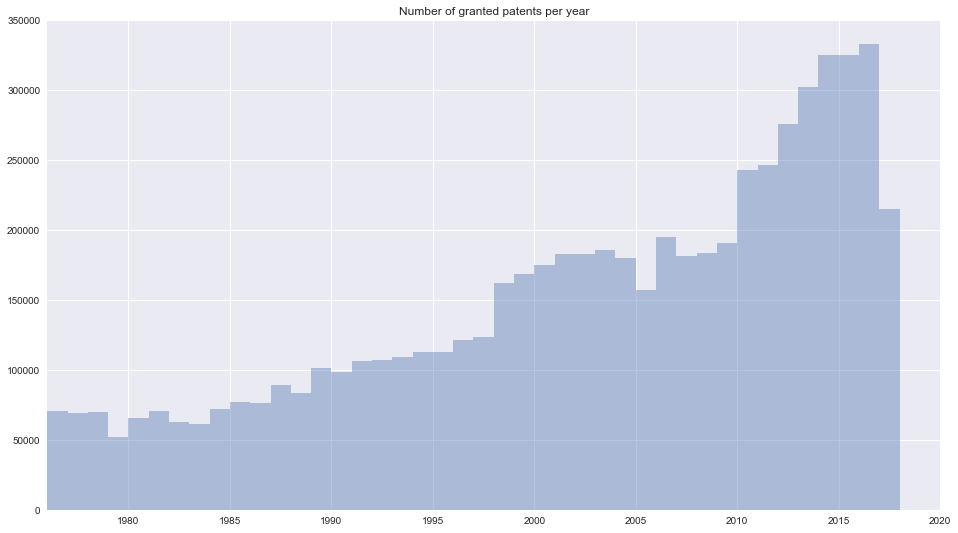

In [491]:
years = np.array(patents.date.str[:4], np.int16)

_, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_title('Number of granted patents per year')
_ = sns.distplot(years, bins=np.arange(1976, 2019, 1), ax=ax, kde=False).set(xlim=(1976, 2020))

<Container object of 31 artists>

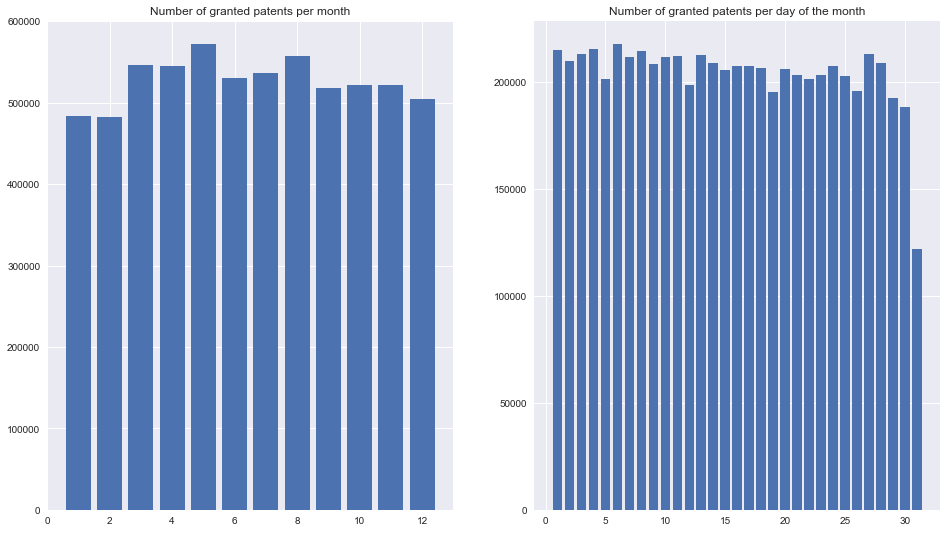

In [495]:
months = np.array(patents.date.str[5:7], np.int16)
unique, counts = np.unique(months, return_counts=True)

plt.subplot(121)
plt.title('Number of granted patents per month')
plt.bar(np.arange(1, 13, 1), counts)

days = np.array(patents.date.str[8:10], np.int16)
unique, counts = np.unique(days, return_counts=True)

plt.subplot(122)
plt.title('Number of granted patents per day of the month')
plt.bar(np.arange(1, 32, 1), counts)

### 3.2 Histograms over Types <a id="32"></a>

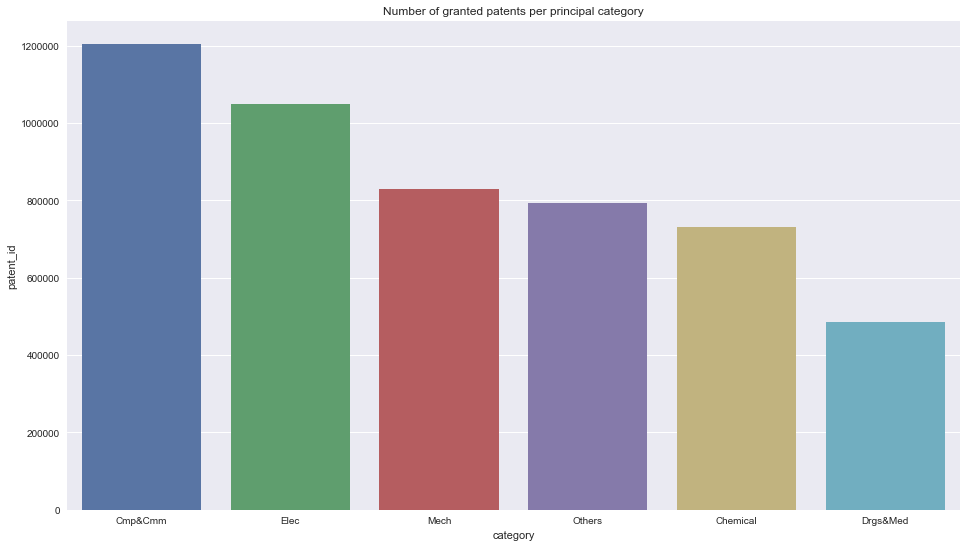

In [493]:
hist = categorymap.groupby('category').count().reset_index().sort_values('patent_id', ascending=False)

ax = plt.axes()
ax.set(ylabel=None, title='Number of granted patents per principal category')

sns.barplot(x='category', y='patent_id', data=hist, ax=ax)

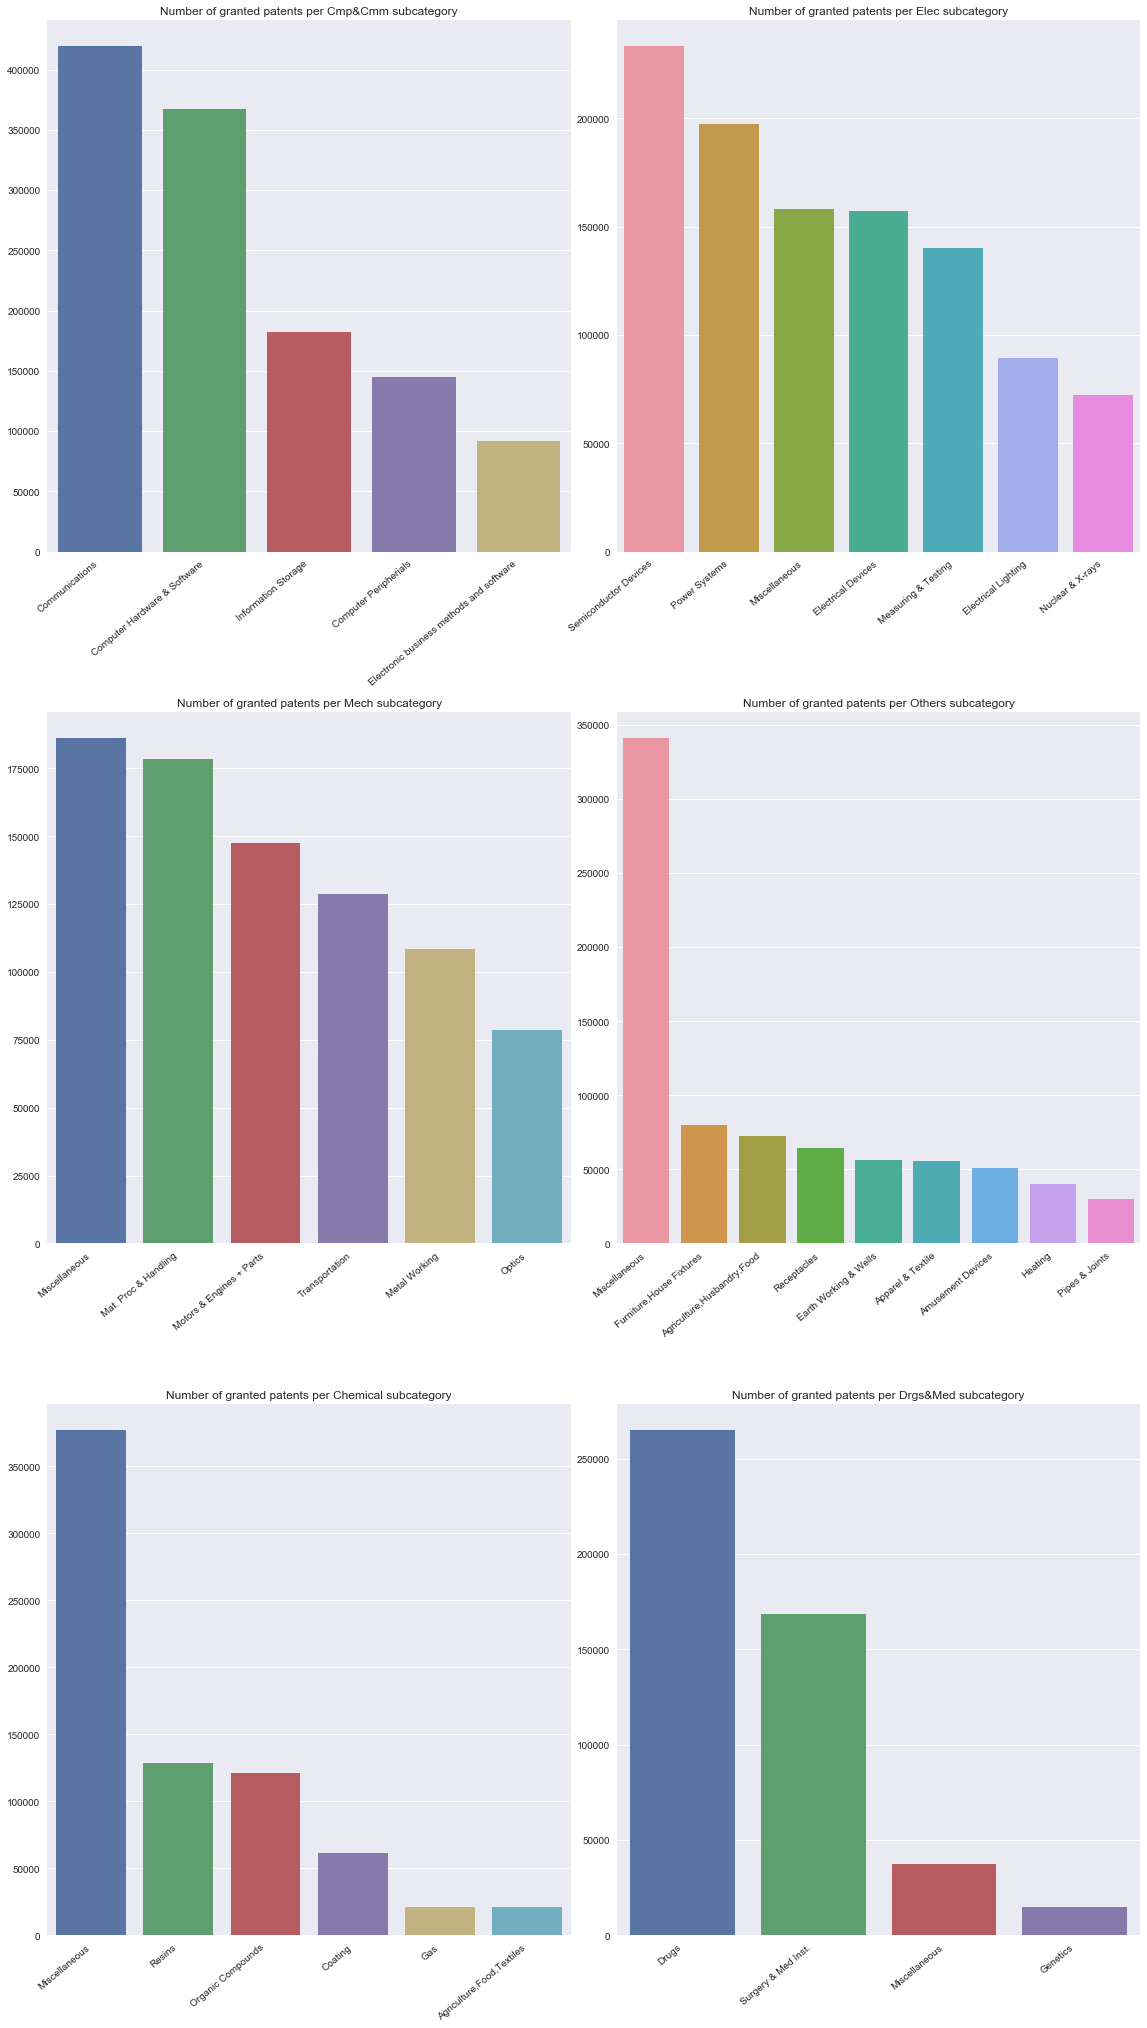

In [494]:
fig, axs = plt.subplots(3, 2, figsize=(16, 6))
fig.tight_layout()
plt.subplots_adjust(top=4.5)

plots = ['Cmp&Cmm', 'Elec', 'Mech', 'Others', 'Chemical', 'Drgs&Med']
for i in range(3):
    for j in range(2):
        hist = categorymap[categorymap.category == plots[i*2 + j]] \
            .groupby('subcategory').count() \
            .reset_index() \
            .sort_values('patent_id', ascending=False)

        sns.barplot(x='subcategory', y='patent_id', data=hist, ax=axs[i][j])
        axs[i][j].set_title('Number of granted patents per {} subcategory'.format(plots[i*2 + j]))
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
        axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(), rotation=40, ha="right")

## 4. Graph software <a id="4"></a>

### 4.1 What we tried <a id="41"></a>

Our first library of choice was *networkx* to store, analyse and display our graphs. While trying to load the 89 million edges into a graph, we quickly noticed that *networkx* is too slow to handle such data sizes.

Looking for a graph network library that can handle many more nodes and edges, we discovered *graph-tool*. *graph-tool* stores vertices efficiently simply as an index between 0 and V-1, where V is the total number of vertices in the graph. Additional properties of the vertices (like the patent ID to identify them) can be stored alongside in a property variable. *graph-tool*'s algorithms are fast and efficient, but installing it proved to be quite challenging. 

Even though *graph-tool* is much faster than *networkx*, we are still reaching the limit of what our laptops can handle memory-wise (8GB). Therefore, if needed we will use a computer with more memory (16GB) to run more complex algorithms on the data.

### 4.2 Graph visualisation using graph-tool <a id="42"></a>

graph-tool contains its own functions for displaying graphs. We tried to draw smaller graphs of no more than 100 nodes and it worked fine. However, increasing the number of nodes to draw quickly proved infeasible as the computation times were growing rapidly. For this reason, we decided to only use graph-tool's drawing capabilities for smaller visualisations along the road, where we want to display the finer structure of the graph. For interactive visualisations and other graphs for the website, we will investigate D3.js, since we found out that Kirell Benzi uses this library and is getting amazing results from it!

### 4.3 Transforming the citations dataframe to a directed graph <a id="43"></a>

Vertexes in graph-tool are named after an index from 0 to N-1, where N is the number of vertices in the graph. In order to know which vertex is which, we need to store the id of the respective patent inside a property of each vertex. Using graph-tool's inbuilt add\_edge\_list function, we create a graph of all citations and get back a property list with all the integer patent indices.

In [ ]:
graph = Graph()
props = graph.add_edge_list(citations.values, hashed=True)
graph.vertex_properties['id'] = props

### 4.4 Saving the graph to disk <a id="44"></a>

To not be forced to rebuild the graph each time we start our notebook, we decided to save the graph to a gzip compressed file to disk which is roughly 850 MB big. While it takes approximately 5 minutes to load the graph into memory from this file, much time and memory can be saved afterwards by having this concise representation of our graph.

In [ ]:
graph.save(DATA + 'citations_graph.xml.gz')

In [17]:
graph = load_graph(DATA + 'citations_graph.xml.gz')

## 5. Statistics on the Graph <a id="5"></a>

### 5.1 Working with the graph <a id="51"></a>

In this section we list useful functions that facilitate working with the graph:

In [25]:
# Extracting the properties of the graph vertices and getting the transformed patent id back:
x = graph.vp.id['12345']
int_to_hex(x)

'8828082'

In [26]:
# To extract a node with a given graph vertex index:
v = graph.vertex(12345)
v

<Vertex object with index '12345' at 0x7f9f592a48d0>

In [27]:
# Method 1 of retrieving the graph index of a given vertex
graph.vertex_index[v]

12345

In [28]:
# Method 2 of retrieving the graph index of a given vertex
int(v)

12345

In [29]:
# To extract an edge with given graph vertex indices
graph.edge(0,1)

<Edge object with source '0' and target '1' at 0x7f9f5920d468>

### 5.2 Graph Overview <a id="52"></a>

Our final directed graph comprises over 8 million nodes that are connected with over 85 million edges!

In [30]:
vertices = [int(v) for v in graph.vertices()]
print('Number of vertices:', graph.num_vertices())
print('Number of edges', graph.num_edges())

Number of vertices: 8274991
Number of edges 86284396


At first glance, it would be assumed that a patents graph is acyclic, since cycles would mean that there is a violation of temporal causality (patents cite future patents). However, using the *graph-tool* function *is_DAG*, we find out that, contrary to our assumptions, the directed graph is cyclic. A reason for this could be that patents cite patent applications that then become granted patents in the future. Another possible reason could be human mistakes. We will investigate this fact further.

In [31]:
# Is this graph a Directed Acyclic Graph?
is_DAG(graph)

False

### 5.3 Vertex In- and Out-degrees <a id="53"></a>

To get a sense of how connected our graph is, we calculate the in-degree (number of ingoing edges) and the out-degree (number of outgoing edges) for every node. The average in-degree should equal the average out-degree, since every edge has to have a source and target node.

Additionally, we list the top 10 patents of largest in- and out-degrees.

#### By in-degree

In [32]:
# Getting the in-degree of each vertex
in_deg = graph.get_in_degrees(vertices)

In [33]:
# Average in-degree
in_deg.mean()

10.427128682073491

In [34]:
# Median in-degree
np.median(in_deg)

3.0

In [35]:
# Listing the top 10 nodes by in-degree

max_in_degs = heapq.nlargest(10, enumerate(in_deg), key=lambda x: x[1])

print("Top 10 patents of largest in-degree:\n")
for idx, deg in enumerate(max_in_degs):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    patent_title = patent_info['patents'][0]['patent_title']
    
    print('Nr {}:\t{}'.format(idx+1, patent_title))
    print('\tDegree = {}, Patent ID = {}\n'.format(deg[1], patent_id))

Top 10 patents of largest in-degree:

Nr 1:	Process for amplifying nucleic acid sequences
	Degree = 3709, Patent ID = 4683202

Nr 2:	Mutant dwarfism gene of petunia
	Degree = 3342, Patent ID = 5523520

Nr 3:	Process for amplifying, detecting, and/or-cloning nucleic acid sequences
	Degree = 3188, Patent ID = 4683195

Nr 4:	Expandable intraluminal graft, and method and apparatus for implanting an expandable intraluminal graft
	Degree = 2697, Patent ID = 4733665

Nr 5:	Systems and methods for secure transaction management and electronic rights protection
	Degree = 2451, Patent ID = 5892900

Nr 6:	Methods for forming liquid crystal displays including thin film transistors and gate pads having a particular structure
	Degree = 2377, Patent ID = 5731856

Nr 7:	Semiconductor device and manufacturing method thereof
	Degree = 2367, Patent ID = 7674650

Nr 8:	Natural-superlattice homologous single crystal thin film, method for preparation thereof, and device using said single crystal thin film
	D

#### By out-degree

In [36]:
# Getting out-degrees of each vertex
out_deg = graph.get_out_degrees(vertices)

In [37]:
# Average out-degree (should be the same as average in-degree)
out_deg.mean()

10.427128682073491

In [38]:
# Median out-degree
np.median(out_deg)

4.0

In [39]:
# Listing the top 10 nodes by out-degree

max_out_degs = heapq.nlargest(10, enumerate(out_deg), key=lambda x: x[1])

print("Top 10 vertices of largest out-degree:\n")
for idx, deg in enumerate(max_out_degs):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    patent_title = patent_info['patents'][0]['patent_title']
    
    print('Nr {}:\t{}'.format(idx+1, patent_title))
    print('\tDegree = {}, Patent ID = {}\n'.format(deg[1], patent_id))

Top 10 vertices of largest out-degree:

Nr 1:	Internet appliance system and method
	Degree = 5832, Patent ID = 9535563

Nr 2:	Adaptive pattern recognition based controller apparatus and method and human-interface therefore
	Degree = 5819, Patent ID = 8892495

Nr 3:	Alarm system controller and a method for controlling an alarm system
	Degree = 3032, Patent ID = 8369967

Nr 4:	System, method and computer program product for a collaborative decision platform
	Degree = 2880, Patent ID = 8160988

Nr 5:	System, method and computer program product for a collaborative decision platform
	Degree = 2844, Patent ID = 8005777

Nr 6:	System, method and computer program product for a collaborative decision platform
	Degree = 2823, Patent ID = 7970722

Nr 7:	Staple cartridge comprising an implantable layer
	Degree = 2681, Patent ID = 9724098

Nr 8:	Adjunct with integrated sensors to quantify tissue compression
	Degree = 2679, Patent ID = 9724094

Nr 9:	Firing member retraction devices for powered surg

#### Histogram of vertices by in-degree

To visually assess how the number of vertices per in-degree are distributed, we decided to plot both histograms where the y axis is scaled normally and using a log-scale, as well as a log-log plot. 

If the distribution of in-degrees was exponential, we would see a straight line in the second plot, whereas if it was distributed according to a power law, we would observe a straight line in the log-log plot. Neither are the case and therefore we do not observe a power law. This means that patents that have been cited only a few times are very common, whereas highly cited patents are rare.

In [56]:
vhist_in = vertex_hist(graph, 'in')

<function matplotlib.pyplot.show>

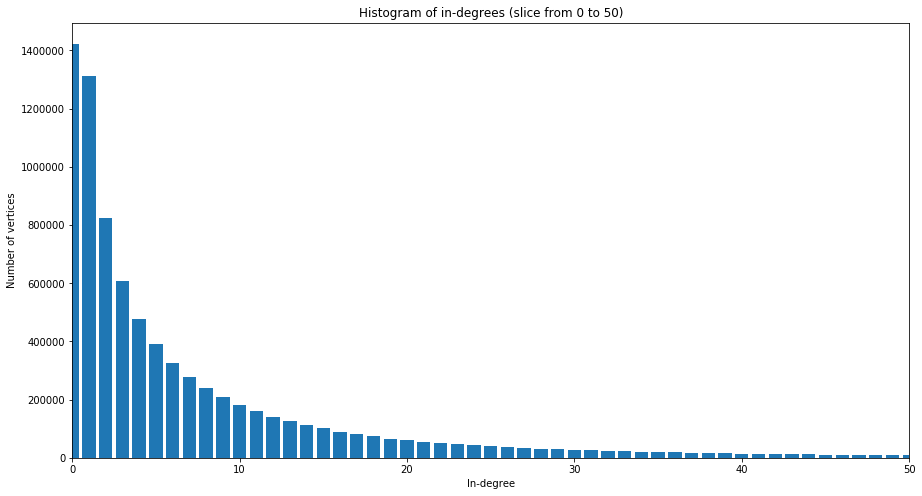

In [54]:
plt.figure(1, figsize=(15, 8))
plt.title('Histogram of in-degrees (slice from 0 to 50)')
plt.bar(vhist_in[1][:-1], vhist_in[0])
plt.xlim((0,50))
plt.xlabel('In-degree')
plt.ylabel('Number of vertices')
plt.show

<function matplotlib.pyplot.show>

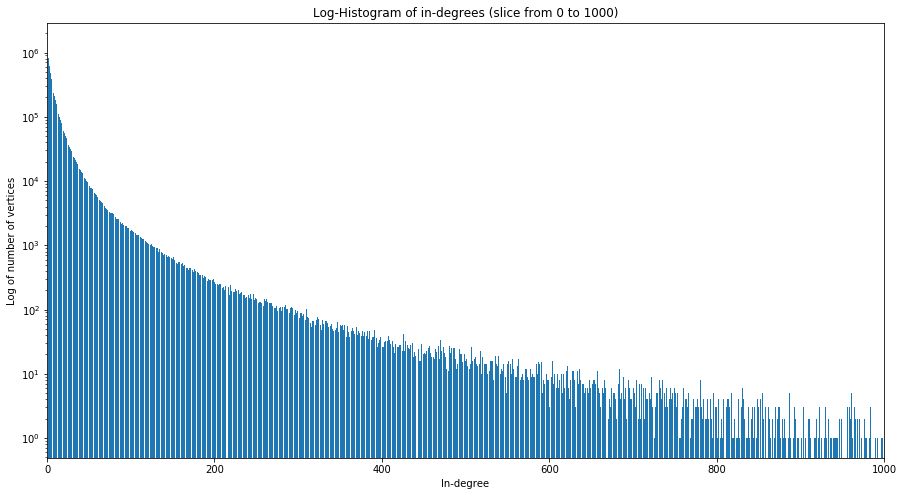

In [53]:
plt.figure(1, figsize=(15, 8))
plt.title('Log-Histogram of in-degrees (slice from 0 to 1000)')
plt.bar(vhist_in[1][:-1], vhist_in[0], log=True)
plt.xlim((0,1000))
plt.xlabel('In-degree')
plt.ylabel('Log of number of vertices')
plt.show

<function matplotlib.pyplot.show>

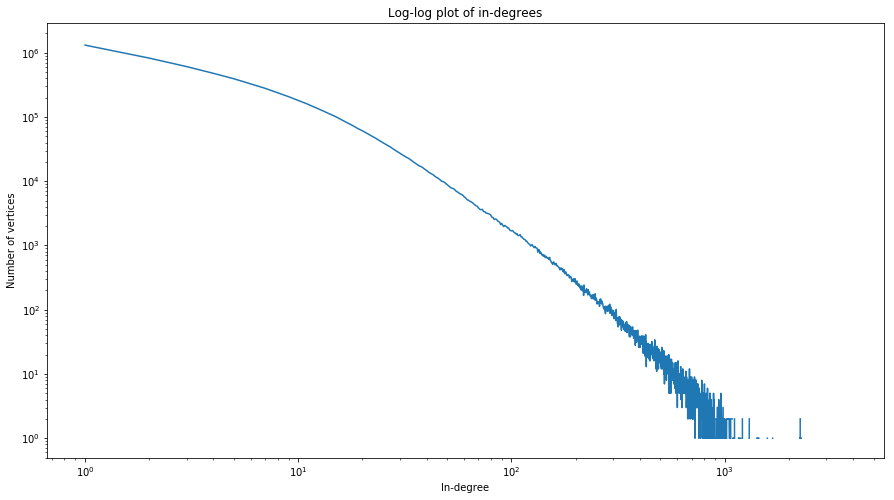

In [43]:
plt.figure(1, figsize=(15, 8))
plt.title('Log-log plot of in-degrees')
plt.loglog(vhist_in[1][:-1], vhist_in[0])
plt.xlabel('In-degree')
plt.ylabel('Number of vertices')
plt.show

#### Histogram of vertices by out-degree

Like before, we plot both histograms where the y axis is scaled normally and using a log-scale, as well as a log-log plot of the number of vertices per out-degree.

In the first plot, it becomes clear that roughly one third of all patents in our graph did not cite other patents. Most of them are patents that were issued before 1976, for which we do not have more data available in our data sets. We also observe a spike in the beginning, meaning that citing 3 or 4 patents is most common.

If it was distributed according to a power law, we would observe a straight line in the log-log plot. For out-degrees between 0 and 10, we do not observe such a straight line, but from 10 upwards it becomes apparent that there must be a power law. This means that patents citing many other patents is not uncommon.

In [45]:
vhist_out = vertex_hist(graph, 'out')

<function matplotlib.pyplot.show>

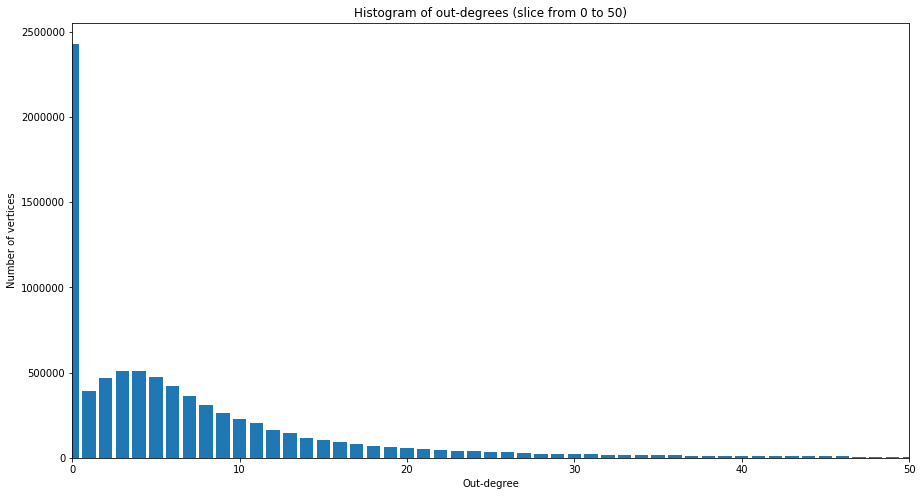

In [55]:
plt.figure(1, figsize=(15, 8))
plt.title('Histogram of out-degrees (slice from 0 to 50)')
plt.bar(vhist_out[1][:-1], vhist_out[0])
plt.xlim((0,50))
plt.xlabel('Out-degree')
plt.ylabel('Number of vertices')
plt.show

<function matplotlib.pyplot.show>

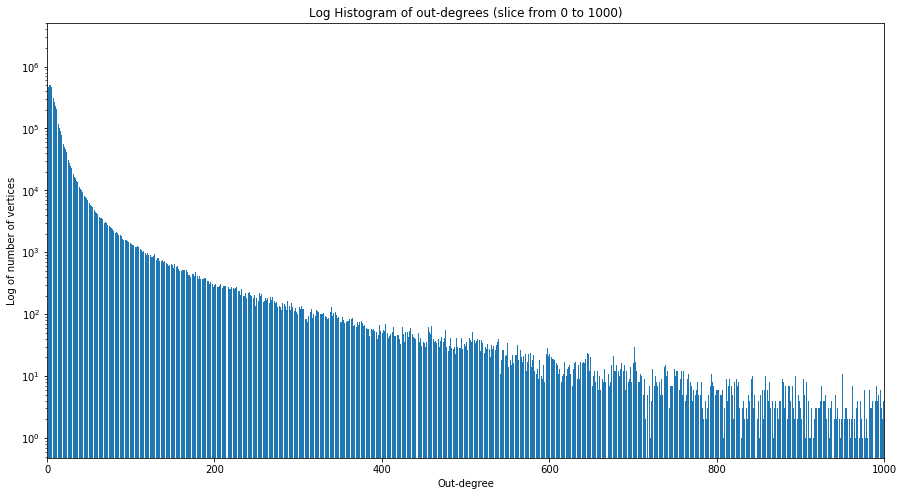

In [47]:
plt.figure(1, figsize=(15, 8))
plt.title('Log Histogram of out-degrees (slice from 0 to 1000)')
plt.bar(vhist_out[1][:-1], vhist_out[0], log=True)
plt.xlim((0,1000))
plt.xlabel('Out-degree')
plt.ylabel('Log of number of vertices')
plt.show

<function matplotlib.pyplot.show>

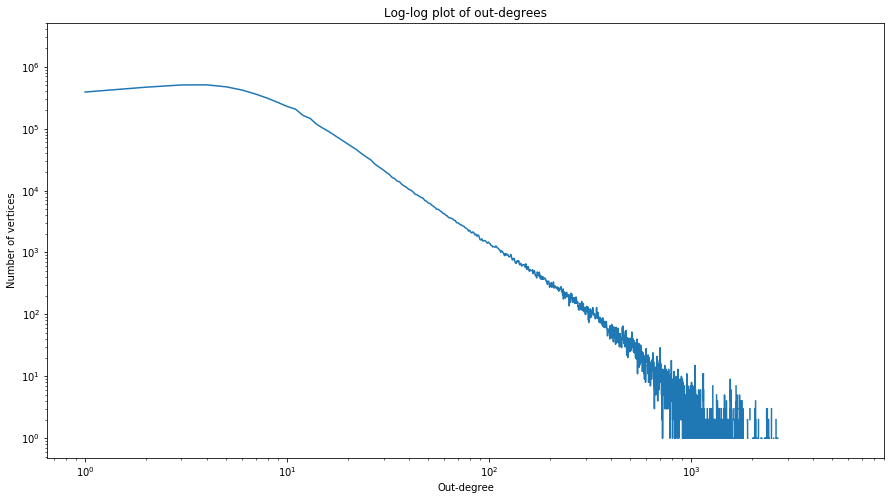

In [48]:
plt.figure(1, figsize=(15, 8))
plt.title('Log-log plot of out-degrees')
plt.loglog(vhist_out[1][:-1], vhist_out[0])
plt.xlabel('Out-degree')
plt.ylabel('Number of vertices')
plt.show

### 5.4 Shortest Path Between Selected Nodes <a id="54"></a>

One of the central premises of our project idea was to find out how connected the patents in the graph actually are. One important step for this goal is to see if there even exists any path between two important patents of our choice and how short this path can be. We therefore compute the shortest path and print it out if it exists. Below, some examples of this pipeline are listed.

Some interesting patent ids:

- Google page rank: 6285999
- Snapchat Augmented Reality: 9652896
- Dropbox Network folder synchronization: 8825597
- Facebook Dynamically generating a privacy summary: 8225376
- SolarCity Methods for financing renewable energy systems: 7904382
- GoPro Harness system for attaching camera to user: 6955484
- Apple Microcomputer for use with video display 4136359
- Semiconductor: 2981877

In [52]:
def list_shortest_path(source, target, graph, verbose=False):
    '''Compute and print the shortest path between two patents.
    This function will pull the patent titles from the patentsview.org api.
    
    Keyword arguments:
    source -- Patent id of source node (string)
    target -- Patent id of target node (string)
    graph -- Patent graph
    verbose -- Set to true to print out shortest path (default=False)
    '''
    
    source_int_id = hex_to_int(source)
    target_int_id = hex_to_int(target)
    
    source_vertex = find_vertex(graph, graph.vertex_properties.id, source_int_id)
    if (len(source_vertex) == 0):
        print('Source not found in graph.')
        return None
    
    target_vertex = find_vertex(graph, graph.vertex_properties.id, target_int_id)
    if (len(target_vertex) == 0):
        print('Target not found in graph.')
        return None
    
    path = shortest_path(graph, source_vertex[0], target_vertex[0])
    
    if (len(path[0]) == 0):
        print('The graph contains no path from source to target.')
        return None
    
    if verbose:
        print('Shortest path:\n--------------')
        for idx, v in enumerate(path[0]):
            patent_id = int_to_hex(graph.vp.id[int(v)])
            patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
            patent_info = requests.get(patent_URL).json()
            if (patent_info['patents'] is None):
                patent_title = '-No title available-'
            else:
                patent_title = patent_info['patents'][0]['patent_title']
            print('ID: {}\t{}'.format(patent_id, patent_title))
            if (idx < len(path[0])-1):
                print('↓')
            
    return path

In [50]:
# Shortest path between Snapchat Augmented Reality and Apple II patents
_ = list_shortest_path('9652896', '4136359', graph, verbose=True)

Shortest path:
--------------
ID: 9652896	Image based tracking in augmented reality systems
↓
ID: 9098926	Generating three-dimensional fa&#xe7;ade models from images
↓
ID: 7174039	System and method for embodying virtual reality
↓
ID: 6888552	High dynamic range image editing
↓
ID: 6396505	Methods and apparatus for detecting and reducing color errors in images
↓
ID: 4136359	Microcomputer for use with video display


In [70]:
# Shortest path between Google Page Rank and Semiconductor patents
_ = list_shortest_path('6285999', '2981877', graph, verbose=True)

Shortest path:
--------------
ID: 6285999	Method for node ranking in a linked database
↓
ID: 6014678	Apparatus for preparing a hyper-text document of pieces of information having reference relationships with each other
↓
ID: 5634062	System for managing hypertext node information and link information
↓
ID: 5446891	System for adjusting hypertext links with weighed user goals and activities
↓
ID: 5021976	Method and system for generating dynamic, interactive visual representations of information structures within a computer
↓
ID: 4752893	Graphics data processing apparatus having image operations with transparent color having a selectable number of bits
↓
ID: 4590463	Digital control of color in CRT display
↓
ID: 4276543	Monolithic triple diffusion analog to digital converter
↓
ID: 3981072	Bipolar transistor construction method
↓
ID: 2981877	-No title available-


### 5.5 Speed of Complex Graph Algorithms <a id="55"></a>

Searching the shortest path between two patents running in O(V+E):

In [11]:
source_int_id = hex_to_int('9652896')
target_int_id = hex_to_int('4136359')
source_vertex = find_vertex(graph, graph.vertex_properties.id, source_int_id)
target_vertex = find_vertex(graph, graph.vertex_properties.id, target_int_id)

t = time.process_time()
shortest_path(graph, source_vertex[0], target_vertex[0])
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 0.1490846929999634 seconds


Calculating the histogram of vertex in-degrees running in O(V):

In [44]:
t = time.process_time()
vertex_hist(graph, 'in')
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 0.23201369599996724 seconds


Calculating the minimum spanning tree running in O(E log E):

In [4]:
t = time.process_time()
min_spanning_tree(graph)
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 97.59106510199996 seconds


Calculating an iterator for all the cycles in the graph running in worst time complexity O((V+E)\*(C+1)), where C is the number of cycles:

In [5]:
t = time.process_time()
all_circuits(graph)
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 71.96241059899995 seconds


We tried running an O(V^2) algorithm (shortest-distance histogram for each vertex pair in the graph) but it did not finish in a reasonable amount of time. Assuming 8 Million vertices, V^2 is in the order of 6.4e+13, which would take days to compute. We will therefore not use algorithms of this complexity and resort to approximating our results by sampling a random (but not too small) subset of the graph. Below is a test of this function with a small sample size.

In [102]:
t = time.process_time()
dist_hist = distance_histogram(graph, samples=1000)
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 552.3472660000001 seconds


<function matplotlib.pyplot.show>

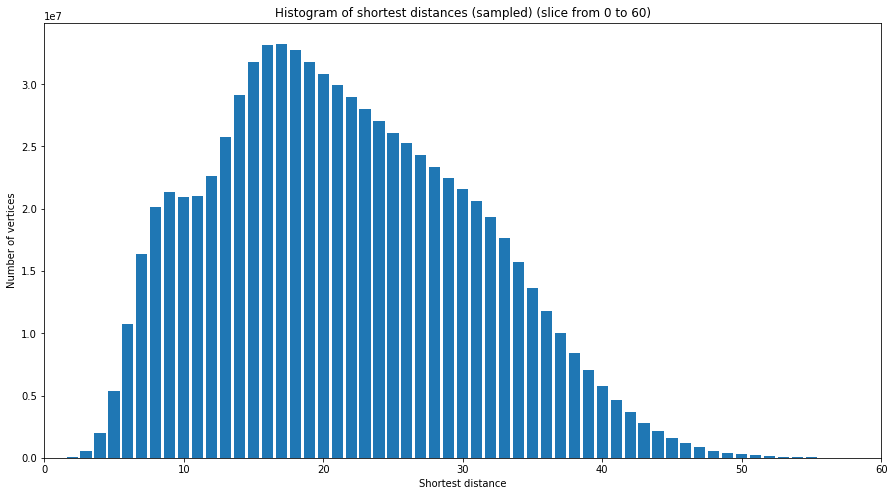

In [103]:
plt.figure(1, figsize=(15, 8))
plt.title('Histogram of shortest distances (sampled) (slice from 0 to 60)')
plt.bar(dist_hist[1][:-1], dist_hist[0])
plt.xlim((0,60))
plt.xlabel('Shortest distance')
plt.ylabel('Number of vertices')
plt.show

### 5.6 Connected Components <a id="56"></a>

To get a good sense of the topology of our graph, it is useful to know what and how big the connected compontents are. Hereby, we will calculate all connected components assuming undirectedness of the graph.

In [68]:
comp_prop = label_largest_component(graph, directed=False)
comp_arr = comp_prop.get_array()

In [70]:
comp_arr.shape

(8274991,)

In [74]:
comp_arr[comp_arr == 1].shape

(8261059,)

We get a surprising and very interesting result! Almost the whole graph (99.998%) is connected! This means that almost every invention is in some sense connected with the larger tree of preceding patents.

## 6. Most important patents <a id="6"></a>

We would like to see which are the most important US patents between 1976 and 2016. For this purpose, we first get the 1000 nodes with the highest in degree and the 1000 nodes with the highest page rank.

In [4]:
# Getting the in-degree of each vertex
vertices = [int(v) for v in graph.vertices()]
in_deg = graph.get_in_degrees(vertices)

In [ ]:
highest_in = []

max_in_degs = heapq.nlargest(1000, enumerate(in_deg), key=lambda x: x[1])

for idx, deg in enumerate(max_in_degs):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    if patent_info['patents']:
        patent_title = patent_info['patents'][0]['patent_title']
    else:
        patent_title = '- No title available -'
    in_degree = deg[1]
    highest_in.append([patent_id, in_degree, patent_title])
    if idx % 100 == 0:
        print(idx)

To work be able to work with it outside of a jupyter notebook, we export it as a csv:

In [55]:
highest_in = np.array(highest_in)
output_file = open('./csvs/highest_in.csv', 'w')
with output_file:  
    writer = csv.writer(output_file)
    writer.writerow(['patent_id', 'in_degree', 'patent_title'])
    writer.writerows(highest_in)

Now we calculate the page rank of each patent node in the citations graph. This algorithm does not take too long to compute.

In [56]:
pr = pagerank(graph)

In [ ]:
highest_pr = []

max_pr = heapq.nlargest(1000, enumerate(pr), key=lambda x: x[1])

for idx, deg in enumerate(max_pr):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    if patent_info['patents']:
        patent_title = patent_info['patents'][0]['patent_title']
    else:
        patent_title = '- No title available -'
    rank = deg[1]
    highest_pr.append([patent_id, rank, patent_title])
    if idx % 100 == 0:
        print(idx)

Again we save the top 1000 nodes to a csv file:

In [63]:
highest_pr = np.array(highest_pr)
output_file = open('./csvs/highest_pr.csv', 'w')
with output_file:  
    writer = csv.writer(output_file)
    writer.writerow(['patent_id', 'pagerank', 'patent_title'])
    writer.writerows(highest_pr)

We can load the saved files again in the following way:

In [3]:
top_in_deg = pd.read_csv('./csvs/highest_in.csv')
top_in_deg.patent_id = top_in_deg.patent_id.apply(str)
top_pr = pd.read_csv('./csvs/highest_pr.csv')
top_pr.patent_id = top_pr.patent_id.apply(str)

In [4]:
top_in_deg.head()

,patent_id,in_degree,rank_in,patent_title_in
0,4683202,3709,1,Process for amplifying nucleic acid sequences
1,5523520,3342,2,Mutant dwarfism gene of petunia
2,4683195,3188,3,"Process for amplifying, detecting, and/or-clon..."
3,4733665,2697,4,"Expandable intraluminal graft, and method and ..."
4,5892900,2451,5,Systems and methods for secure transaction man...


In [5]:
top_pr.head()

,patent_id,pagerank,rank_pr,patent_title_pr
0,4237224,0.000029,1,Process for producing biologically functional ...
1,3813316,0.000025,2,- No title available -
2,4309756,0.000019,3,Method of automatically evaluating source lang...
3,4558413,0.000018,4,Software version management system
4,4395486,0.000017,5,Method for the direct analysis of sickle cell ...


We would like to see which are the "best" patents from both rankings. For this, it comes natural to take the average rank and sort by it.

In [11]:
merged = top_in_deg.merge(top_pr, on='patent_id', how='inner')
merged['rank_avg'] = (merged.rank_in + merged.rank_pr) / 2
merged = merged.sort_values('rank_avg')
merged.head(10)

,patent_id,in_degree,rank_in,patent_title_in,pagerank,rank_pr,patent_title_pr,rank_avg
0,4683202,3709,1,Process for amplifying nucleic acid sequences,0.000017,6,Process for amplifying nucleic acid sequences,3.5
2,4683195,3188,3,"Process for amplifying, detecting, and/or-clon...",0.000017,7,"Process for amplifying, detecting, and/or-clon...",5.0
1,5523520,3342,2,Mutant dwarfism gene of petunia,0.000013,10,Mutant dwarfism gene of petunia,6.0
7,4723129,1871,31,Bubble jet recording method and apparatus in w...,0.000008,34,Bubble jet recording method and apparatus in w...,32.5
8,5572643,1811,34,Web browser with dynamic display of informatio...,0.000008,36,Web browser with dynamic display of informatio...,35.0
12,4463359,1680,38,Droplet generating method and apparatus thereof,0.000008,32,Droplet generating method and apparatus thereof,35.0
19,5103459,1554,48,System and method for generating signal wavefo...,0.000009,23,System and method for generating signal wavefo...,35.5
33,4901307,1407,67,Spread spectrum multiple access communication ...,0.000008,29,Spread spectrum multiple access communication ...,48.0
17,4740796,1587,46,Bubble jet recording method and apparatus in w...,0.000006,83,Bubble jet recording method and apparatus in w...,64.5
21,4558333,1476,51,Liquid jet recording head,0.000006,103,Liquid jet recording head,77.0


In [9]:
len(merged)

98

In [17]:
merged.to_csv('./csvs/highest_merged.csv')

To assess how simmilar the two ranking methods perform, we can plot a histogram of the number of patents for both rankings. Below, we see that many of the top 50 patents by in degree are also in the top 1000 patents by PageRank, but otherwise, there is not a big correlation to be seen in the two metrics.

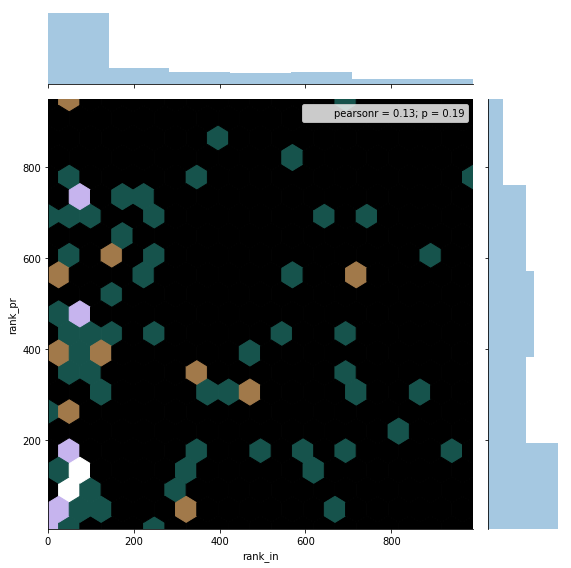

In [8]:
sns.jointplot(x='rank_in', y='rank_pr', data=merged, kind='hex', cmap= 'cubehelix', size=8, gridsize=20)

## 7. Shortest path between multiple sources and sinks <a id="7"></a>

For the website, we want to display an interactive graph showing all possible shortest paths between some selected source patents to some selected sink patents. 

First we calculate all shortest paths to every node in the graph using a breadth first search. Then we extract the shortest paths to the nodes we want to display and fetch the patent titles from the patentsview.org website. Finally we save all the found edges and nodes in csv files to load up and arrange in Gephi, from which we can in turn export the graph into a format readable by Sigma JS to display on the website.

In [4]:
class ShortestPathVisitor(BFSVisitor):
    '''
    Visits all nodes reachable from a source node and saves
    shortest distance and list of predecessor nodes to get
    back to the source node.
    '''
    def __init__(self, name, pred, dist):
        self.name = name
        self.pred = pred
        self.dist = dist
            
    def examine_edge(self, e):
        # Getting distance of next node
        next_dist = self.dist[e.source()] + 1
            
        # Checking if target has shorter connections
        if self.pred[e.target()]:
            if next_dist == self.dist[e.target()]:
                self.pred[e.target()].append(int(e.source()))
        else: # First to discover is shortest
            self.pred[e.target()].append(int(e.source()))
            self.dist[e.target()] = next_dist

In [5]:
def all_shortest_paths(graph, pred, source, sink):
    '''Returns all shortest paths from a source to a sink.
    Uses graph indices.
    Returns vertex set, edge set.'''
    if (source == sink):
        return set([sink]), set()
    
    vertices = set([sink])
    edges = set()
    
    for v in pred[sink]:
        edges.add((v,sink))
        v_rec, e_rec = all_shortest_paths(graph, pred, source, v)
        vertices = vertices | v_rec
        edges = edges | e_rec
        
    return vertices, edges

In [6]:
def all_shortest_paths_combined(graph, source_list, sink_list):
    '''Compute all shortest paths between all sources and all sinks to form a graph of those connections.
    Sources and sinks are patent ids (strings).'''
    
    vertices = set()
    edges = set()
    
    for source in source_list:
        print('Computing all shortest paths from ' + source)
        dist = graph.new_vertex_property("int")
        pred = graph.new_vertex_property("vector<int32_t>")
        
        source_vertex = find_vertex(graph, graph.vertex_properties.id, hex_to_int(source))[0]
        bfs_search(graph, int(source_vertex), ShortestPathVisitor('SPV_' + source, pred, dist))
        
        for sink in sink_list:
            print('\tto ' + sink)
            sink_vertex = find_vertex(graph, graph.vertex_properties.id, hex_to_int(sink))[0]
            vs, es = all_shortest_paths(graph, pred, int(source_vertex), int(sink_vertex))
            vertices = vertices | vs
            edges = edges | es
        
    return vertices, edges      

In [8]:
source_list = ['6285999', '8046721', '8930044']
sink_list = ['2981877', '821393', '676332']

In [9]:
asp = all_shortest_paths_combined(graph, source_list, sink_list)

Computing all shortest paths from 6285999
	to 2981877
	to 821393
	to 676332
Computing all shortest paths from 8046721
	to 2981877
	to 821393
	to 676332
Computing all shortest paths from 8930044
	to 2981877
	to 821393
	to 676332


Convert paths to CSVs:

In [10]:
def paths_vertices_to_csv(paths, filename):
    vertices = []
    
    for p in paths: # For each path
        for v in p[0]: # For all the vertices in that path
            patent_id = int_to_hex(graph.vp.id[int(v)])
            patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
            patent_info = requests.get(patent_URL).json()
            if (patent_info['patents'] is None):
                patent_title = '-No title available-'
            else:
                patent_title = patent_info['patents'][0]['patent_title']
            vertices.append([patent_id, patent_title])
            
    output_file = open(filename, 'w')
    with output_file:  
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Label'])
        writer.writerows(vertices)

    return vertices

In [11]:
vertices = paths_vertices_to_csv([asp], './csvs/path_vertices.csv')

In [12]:
def paths_edges_to_csv(paths, filename):
    edges = []
    
    for p in paths: # For each path
        for e in p[1]: # For all the edges in that path
            source_index = int(e[0])
            source_id = int_to_hex(graph.vp.id[source_index])
            target_index = int(e[1])
            target_id = int_to_hex(graph.vp.id[target_index])
            
            edges.append([source_id, target_id])
            
    output_file = open(filename, 'w')
    with output_file:  
        writer = csv.writer(output_file)
        writer.writerow(['Source', 'Target'])
        writer.writerows(edges)
        
    return edges

In [13]:
edges = paths_edges_to_csv([asp], './csvs/path_edges.csv')

## 8. Shortest paths with distances <a id="8"></a>

For the next visualisation, we want to show the shortest path from one source node to many selected sink nodes. We want to save the distance to the source to allow for an appealing visualisation where the distance is hierarchically separated.

We use the same pipeline as before again to display the interactive graph on the website.

In [ ]:
def all_shortest_paths_combined_dist(graph, source, sink_list, dist, pred):
    vertices = set()
    edges = set()
    
    print('Computing all shortest paths from ' + source)    
    source_vertex = find_vertex(graph, graph.vertex_properties.id, hex_to_int(source))[0]
    bfs_search(graph, int(source_vertex), ShortestPathVisitor('SPV_' + source, pred, dist))
        
    for sink in sink_list:
        print('\tto ' + sink)
        sink_vertex = find_vertex(graph, graph.vertex_properties.id, hex_to_int(sink))[0]
        vs, es = all_shortest_paths(graph, pred, int(source_vertex), int(sink_vertex))
        vertices = vertices | vs
        edges = edges | es
        
    return vertices, edges      

In [ ]:
source = '6285999'
sink_list = ['4136359', '2981877', '223898', \
             '821393', '3009235', '1143542', '676332']

In [ ]:
dist = graph.new_vertex_property("int")
pred = graph.new_vertex_property("vector<int32_t>")

asp = all_shortest_paths_combined_dist(graph, source, sink_list, dist, pred)

In [ ]:
max_dist = 0

for sink in sink_list:
    sink_vertex = find_vertex(graph, graph.vertex_properties.id, hex_to_int(sink))[0]
    sink_dist = dist[sink_vertex]
    if sink_dist > max_dist:
        max_dist = sink_dist

Convert paths to CSVs:

In [ ]:
def paths_vertices_to_csv_dist(paths, filename, dist, max_dist):
    vertices = []
    
    for p in paths: # For each path
        for v in p[0]: # For all the vertices in that path
            patent_id = int_to_hex(graph.vp.id[int(v)])
            patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
            patent_info = requests.get(patent_URL).json()
            if (patent_info['patents'] is None):
                patent_title = '-No title available-'
            else:
                patent_title = patent_info['patents'][0]['patent_title']
            vertex_dist = '<[' + str(dist[v]) + ',' + str(max_dist) + ']>'
            z = dist[v]
            vertices.append([patent_id, vertex_dist, z, patent_title])
            
    output_file = open(filename, 'w')
    with output_file:  
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Interval', '[z]', 'Label'])
        writer.writerows(vertices)

    return vertices

In [ ]:
vertices = paths_vertices_to_csv_dist([asp], './path_vertices_dist.csv', dist, max_dist)

In [ ]:
def paths_edges_to_csv_dist(paths, filename):
    edges = []
    
    for p in paths: # For each path
        for e in p[1]: # For all the edges in that path
            source_index = int(e[0])
            source_id = int_to_hex(graph.vp.id[source_index])
            target_index = int(e[1])
            target_id = int_to_hex(graph.vp.id[target_index])
            
            edges.append([source_id, target_id])
            
    output_file = open(filename, 'w')
    with output_file:  
        writer = csv.writer(output_file)
        writer.writerow(['Source', 'Target'])
        writer.writerows(edges)
        
    return edges

In [ ]:
edges = paths_edges_to_csv_dist([asp], './path_edges_dist.csv')

## 9. Visualisation of the lifetime of a node and its closest neighbours <a id="9"></a>



In [6]:
class ShortestPathVisitor(BFSVisitor):
    def __init__(self, name, dist, edge_set, vertex_set, max_dist):
        self.name = name
        self.dist = dist
        self.edge_set = edge_set
        self.vertex_set = vertex_set
        self.max_dist = max_dist
            
    def examine_edge(self, e):
        # Getting distance of next node
        next_dist = self.dist[e.source()] + 1
        self.dist[e.target()] = next_dist
        
        if next_dist <= self.max_dist:
            self.edge_set.add((int(e.source()), int(e.target())))
            self.vertex_set.add(int(e.target()))

In [61]:
dist = graph.new_vertex_property("int")
edge_set = set()
vertex_set = set()

source = '4200770'
source_vertex = find_vertex(graph, graph.vertex_properties.id, hex_to_int(source))[0]
vertex_set.add(int(source_vertex))

bfs_search(graph, int(source_vertex), ShortestPathVisitor('SPV_' + source, dist, edge_set, vertex_set, 2))

In [10]:
reader = csv.reader(open(DATA + 'patent_dates.csv', 'r'))
dates = {}
for row in reader:
    k, v = row
    dates[k] = v

In [64]:
def vertices_to_csv(vertex_set, filename):
    vertices = []
    
    for v in vertex_set: # For all the vertices in that path
        patent_id = int_to_hex(graph.vp.id[int(v)])
        if patent_id in dates:
            year = '<[' + dates[patent_id][:4] + ',2017]>'
        else:
            year = '<[0,0]>'
        vertices.append([patent_id, year])
            
    output_file = open(filename, 'w')
    with output_file:  
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Interval'])
        writer.writerows(vertices)

    return vertices

In [65]:
vertices = vertices_to_csv(vertex_set, './lifetime_vertices.csv')

In [66]:
def edges_to_csv(edge_set, filename):
    edges = []
    
    for e in edge_set: # For all the edges in that path
        source_index = int(e[0])
        source_id = int_to_hex(graph.vp.id[source_index])
        target_index = int(e[1])
        target_id = int_to_hex(graph.vp.id[target_index])
            
        edges.append([target_id, source_id])
            
    output_file = open(filename, 'w')
    with output_file:  
        writer = csv.writer(output_file)
        writer.writerow(['Source', 'Target'])
        writer.writerows(edges)
        
    return edges

In [67]:
edges = edges_to_csv(edge_set, './lifetime_edges.csv')